# fitting annihilation msr timeseries
Tim Tyree<br>
7.5.2022

In [1]:
from IPython.display import clear_output
clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

import cupy, cudf
from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [22]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# load data

In [37]:
#load spiral tip range time series from cache
#WJ's data for LR model (200x200)
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_range_timeseries.pkl'
# #my data for LR model (200x200) diffCoeff=0.001
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'
#my data for LR model (200x200) diffCoeff=0.0005

data_lst=load_from_pickle(range_data_dir)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df=pd.concat(data_lst)
del data_lst
df.head()

loaded range timeseries from 152 termination events


,annihilation_index,R,tdeath,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,trial_num
6318,0,0.179885,0.0,2352.0,2,144.34804,82.93726,1.23411,0.58661,1.37163,0.35375,1177,0
6316,0,0.489484,2.0,2350.0,2,140.80990,90.10595,1.27602,0.56800,1.45780,0.29252,1176,0
6314,0,1.195989,4.0,2348.0,2,118.89407,108.84410,0.20201,1.87254,0.39609,1.65512,1175,0
6312,0,1.401146,6.0,2346.0,4,106.46835,108.31253,-0.39413,2.37612,0.14468,1.83677,1174,0
6310,1,0.275609,0.0,2346.0,4,76.75345,90.36230,1.62715,0.47231,4.64334,-2.10047,1174,0


# TODO: compute msr

In [38]:
x_values_in=df['tdeath'].values
y_values_in=df['R'].values**2
print(f"tdeath ranges from {np.min(x_values_in)} to {np.max(x_values_in)} ms")
print(f"R^2 ranges from {np.min(y_values_in)} to {np.max(y_values_in)} cm^2")

tdeath ranges from 0.0 to 476.0 ms
R^2 ranges from 6.625912499995173e-08 to 12.393103046431568 cm^2


In [17]:
assert not np.isnan(x_values_in).any() 
assert not np.isnan(y_values_in).any()

In [39]:
#compute bootstrap 
bins=np.arange(0,450,1)
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                               y_values_in,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=10,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,0.0,0.074383,0.0,0.001748,0.0,0.482882,3884
1,2.0,0.216425,0.0,0.005164,0.0,0.430050,3420
2,4.0,0.344195,0.0,0.009660,0.0,0.975827,3105
3,6.0,0.473385,0.0,0.014721,0.0,0.448739,2865
4,8.0,0.609781,0.0,0.019164,0.0,0.490567,2677


In [40]:
df_bootstrap.tail()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
125,250.0,2.779082,0.0,0.934700,0.0,0.013286,11
126,252.0,2.734942,0.0,0.926238,0.0,0.472051,11
127,254.0,2.651019,0.0,0.855917,0.0,0.204930,11
128,256.0,2.488686,0.0,0.748509,0.0,0.323909,11
129,258.0,2.434628,0.0,0.743002,0.0,0.501664,11


In [41]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((130,), (130,), (130,))

Does this appear to intersect at zero?


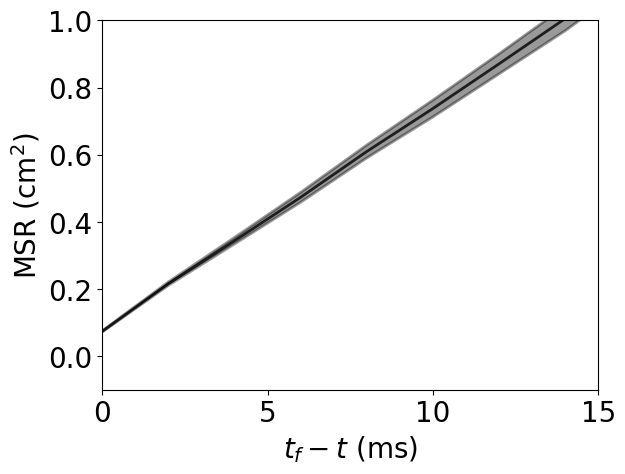

In [42]:
print(f"Does this appear to intersect at zero?")
c='k'
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,15])
plt.ylim([-.1,1])
plt.show()

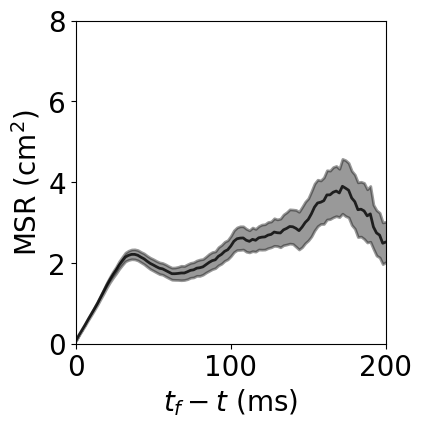

In [43]:
#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
ax.set_ylim([0,8])
plt.show()

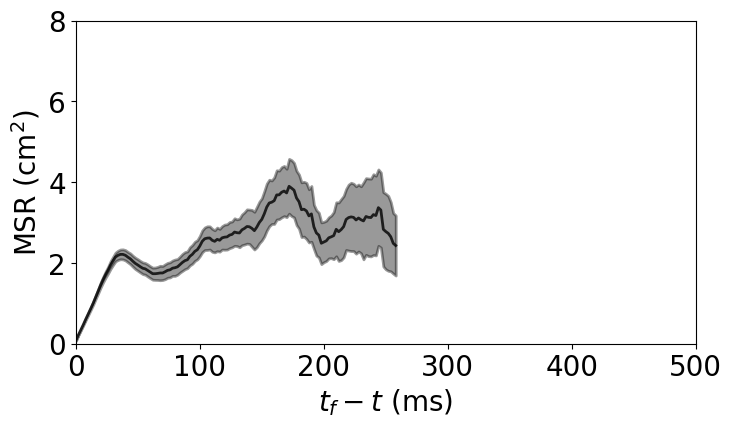

In [44]:
#plot expected
fig,ax=plt.subplots(figsize=(8,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,500])
ax.set_ylim([0,8])
plt.show()

In [45]:
#save msr as .csv
msr_dir_bootstrap=range_data_dir.replace('annihilation_range_timeseries.pkl','annihilation_msr.csv')
df_bootstrap.to_csv(msr_dir_bootstrap,index=False)
print(f"{msr_dir_bootstrap=}")

msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'


In [49]:
#WJ's data for LR model (200x200)
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# #my data for LR model (200x200) diffCoeff=0.001
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
#my data for LR model (200x200) diffCoeff=0.0005


In [50]:
search_for_file()

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv


'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv'

In [2]:
#TODO: fit msr to analytical model solution to the affine oscillatory model, as before, except with period fixed
period=140 #ms

In [52]:
input_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv'
input_folder=os.path.dirname(input_dir)
fn_lst=[os.path.join(input_folder,x) for x in sorted(os.listdir(input_folder)) if x.find('_log.csv')!=-1]
print(f"found {len(fn_lst)} files comparable to {fn_lst[0]}")


found 324 files comparable to /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.0_log.csv
